In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import copy
import torch
from utils import *
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter
from ipywidgets import interact, IntSlider


def wavesubsidence(w_wave, dse, qbg, z, zi):
    """
    Function to compute T and q tendencies from vertical advection

    Inputs:
        w_wave: vertical velocity associated with the large-scale wave
        dse: background profiles of dry static energy divided by Cp
        qbg: background profiles of specific humidity
        z: cell center height
        zi: interface height

    Outputs:
        ttend, qtend: temperature and moisture tendencies
    """
    nzm = len(z)  # number of layers
    ttend = np.zeros(nzm)
    qtend = np.zeros(nzm)

    # centered difference
    for k in range(1, nzm - 1):
        ttend[k] = -w_wave[k] * (dse[k + 1] - dse[k - 1]) / (z[k + 1] - z[k - 1])
        qtend[k] = -w_wave[k] * (qbg[k + 1] - qbg[k - 1]) / (z[k + 1] - z[k - 1])

    # one-sided difference
    ttend[0] = -w_wave[0] * (dse[1] - dse[0]) / (z[1] - z[0])
    ttend[-1] = -w_wave[-1] * (dse[-1] - dse[-2]) / (z[-1] - z[-2])
    qtend[0] = -w_wave[0] * (qbg[1] - qbg[0]) / (z[1] - z[0])
    qtend[-1] = -w_wave[-1] * (qbg[-1] - qbg[-2]) / (z[-1] - z[-2])

    return ttend, qtend


def advancew(t_wave, z, zi, rho, w_wave, t_wavebg, wavenumber_factor):
    """
    Function to compute vertical velocity tendencies from vertical advection

    Inputs:
        t_wave: anomalous associated with the large-scale wave
        z: cell center height
        zi: interface height
        rho: cell center density
        w_wave: vertical velocity
        t_wavebg: reference temperature profile
        wavenumber_factor: controls the horizontal wavenumber. A value of 1 gives a wavelength of 1000km

    Outputs:
        wtend: vertical velocity tendency
    """
    ggr = 9.81  # gravity
    Cp = 1004.0
    wn = wavenumber_factor * 6.283e-6
    wn2 = wn * wn

    nzm = len(z)
    adz = np.zeros(nzm + 1)

    for k in range(1, nzm):
        adz[k] = z[k] - z[k - 1]
    adz[0] = 2 * z[0]
    adz[-1] = 2 * (zi[-1] - z[-1])

    # Gauss Elimination
    rhs = np.zeros(nzm)
    for k in range(nzm):
        rhs[k] = -rho[k] * ggr * wn2 * t_wave[k] / t_wavebg[k] * adz[k] * adz[k + 1] / 2.

    # Set up the tridiagonal matrix
    aa = adz[1:] / (adz[:-1] + adz[1:])
    bb = -np.ones(nzm)
    cc = adz[:-1] / (adz[:-1] + adz[1:])

    # Symmetric lower BC
    aa[0] = 0
    bb[0] = -(2 * adz[1] + adz[0]) / (adz[0] + adz[1])

    # Radiating upper BC
    N2top = ggr / t_wavebg[-1] * ((t_wavebg[-1] - t_wavebg[-2]) / (z[-1] - z[-2]) + ggr / Cp)
    aa[-1] = adz[-1] / adz[-2]
    bb[-1] = -adz[-1] / adz[-2]
    rhs[-1] = rhs[-1] + np.sqrt(N2top) * rho[-1] * wn * w_wave[-1] * adz[-1]

    # Gaussian Elimination with no pivoting
    for k in range(nzm - 1):
        bb[k + 1] = bb[k + 1] - aa[k + 1] / bb[k] * cc[k]
        rhs[k + 1] = rhs[k + 1] - aa[k + 1] / bb[k] * rhs[k]
    # Backward substitution
    rhs[-1] = rhs[-1] / bb[-1]
    for k in range(nzm - 2, -1, -1):
        rhs[k] = (rhs[k] - cc[k] * rhs[k + 1]) / bb[k]
    wtend = rhs / rho
    return wtend

def load_grd_var():
    # Load profile data
    nc_file = '../data/RCE_randmultsine_spinup_256_0_3.nc'
    data = nc.Dataset(nc_file)
    t_wavebg = data.variables['TABS'][:, :].mean(axis=0)
    q_wavebg = data.variables['QV'][:, :].mean(axis=0)
    p = data.variables['p'][:]
    pres = p.squeeze()
    rho = data.variables['RHO'][0, :].squeeze()
    z = data.variables['z'][:]
    data.close()
    
    # Virtual temperature profile
    tv_wavebg = t_wavebg * (1 + 0.61 * q_wavebg / 1000)
    
    nzm = len(z)
    nz = nzm + 1
    ggr = 9.81
    
    # Density at interface levels in kg/m^3
    rhow = np.zeros(nz)
    for k in range(1, nzm):
        rhow[k] = (pres[k - 1] - pres[k]) / (z[k] - z[k - 1]) / ggr * 100
    
    rhow[0] = 2 * rhow[1] - rhow[2]
    rhow[nz - 1] = 2 * rhow[nzm - 1] - rhow[nzm - 2]
    
    dz = 0.5 * (z[0] + z[1])
    adzw = np.zeros(nz)
    adz = np.zeros(nzm)
    for k in range(1, nzm):
        adzw[k] = (z[k] - z[k - 1]) / dz
    
    adzw[0] = 1
    adzw[nz - 1] = adzw[nzm - 1]
    
    adz[0] = 1
    for k in range(1, nzm-1):
        adz[k] = 0.5 * (z[k + 1] - z[k - 1]) / dz
    
    adz[nzm - 1] = adzw[nzm - 1]
    
    # Interface heights
    zi = np.zeros(nz)
    for k in range(1, nz):
        zi[k] = zi[k - 1] + adz[k - 1] * dz
    
    gamaz = z * ggr / 1004.  # Potential energy part of the dry static energy (divided by cp)
    
    return {'z': z, 'zi': zi, 'pres': pres, 't_wavebg': t_wavebg, 'q_wavebg': q_wavebg, 'tv_wavebg': tv_wavebg, 'rho': rho, 'gamaz': gamaz}

def load_params():
    # Read in mass in each layer
    dm = np.loadtxt('IDEAL_dm.txt')
    nT = 26
    nQ = 14
    # Weight variance by mass
    mass_weight = np.diag(np.sqrt(np.concatenate([dm[:nT], (2.5 ** 2) * dm[:nQ], [1.]])))
    
    A, B, C = read_params_from_ssm(64, input_size=40, output_size=41, name_fix="addp_4x")
    return {'A':A, 'B':B, 'C':C, 'mass_weight':mass_weight}

def ReLU(array):
    tmp = array
    tmp[tmp<0] = 0
    return tmp

def input_layer_nonlinear(params, state, input):
    # nonlinear component of state evolution
    tmp1 = ReLU(params['input_layer_1.weight'].numpy() @ np.concatenate((state, input), axis=0) + params['input_layer_1.bias'].numpy()[:, np.newaxis])
    tmp2 = ReLU(params['input_layer_2.weight'].numpy() @ tmp1 + params['input_layer_2.bias'].numpy()[:, np.newaxis])
    tmp3 = params['input_layer_3.weight'].numpy() @ tmp2 + params['input_layer_3.bias'].numpy()[:, np.newaxis]
    #assert tmp3.shape==(60, 1)
    return tmp3

def esatw(t):
    # saturation vapor pressure
    # Constants (same values as in the Fortran code)
    a0 = 6.11239921
    a1 = 0.443987641
    a2 = 0.142986287e-1
    a3 = 0.264847430e-3
    a4 = 0.302950461e-5
    a5 = 0.206739458e-7
    a6 = 0.640689451e-10
    a7 = -0.952447341e-13
    a8 = -0.976195544e-15

    # Temperature difference calculation
    dt = max(-80.0, t - 273.16)

    # Compute esatw using the polynomial expression
    esatw = (a0 + dt * (a1 + dt * (a2 + dt * (a3 + dt * (a4 + dt * 
            (a5 + dt * (a6 + dt * (a7 + a8 * dt))))))))

    return esatw

def qsatw(t, p):
    # saturation specific humidity
    # Calculate esat using the esatw function
    esat = esatw(t)
    
    # Calculate qsatw using the formula
    qsatw_value = 0.622 * esat / max(esat, p - esat)
    return qsatw_value

ssq = qsatw(302.15, 1005.50)

In [2]:
def test_model(wavenumber_factor=0.25, wavedamping_time=1.0, wavetqdamping_time=None, nday=200):
    # load grid variables
    print('Loading grid variables...')
    grd_var = load_grd_var()
    z = grd_var['z']
    zi = grd_var['zi']
    rho = grd_var['rho']
    t_wavebg = grd_var['t_wavebg']
    q_wavebg = grd_var['q_wavebg']
    tv_wavebg = grd_var['tv_wavebg']
    gamaz = grd_var['gamaz']

    # load params
    print('Loading model parameters...')
    dm = np.loadtxt('IDEAL_dm.txt')
    nT = 26
    nQ = 14
    # Weight variance by mass
    mass_weight = np.diag(np.sqrt(np.concatenate([dm[:nT], (2.5 ** 2) * dm[:nQ]])))
    
    linear_params = load_params()
    A = linear_params['A']
    B = linear_params['B']
    C = linear_params['C']
    mass_weight = linear_params['mass_weight']
    
    loadmodel = 'epoch=4579-val_loss=0.095.ckpt'
    checkpoint = torch.load(loadmodel, map_location=torch.device('cpu'))
    nonlinear_params = checkpoint['state_dict']
    
    # local parameters
    dt = 900
    nout = 1
    nT = 26
    nQ = 14
    if wavetqdamping_time is None:
        wavetqdamping_time = wavedamping_time
    wn = wavenumber_factor * 6.283e-6  # 2pi/1000km wavenumber
    nzm = len(z)
    nz = nzm + 1
    nt = int(86400 * nday / dt)
    time = np.arange(0, nt, nout) * dt / 86400

    print('Initializing outputs...')
    rainfall = 0
    
    # Define variables T, q, w
    tout = np.zeros((nzm, nt // nout))
    qout = np.zeros((nzm, nt // nout))
    wout = np.zeros((nzm, nt // nout))
    q1cout = np.zeros((nzm, nt // nout))
    q2out = np.zeros((nzm, nt // nout))
    ttendout = np.zeros((nzm, nt // nout))
    qtendout = np.zeros((nzm, nt // nout))
    precout = np.zeros(nt // nout)
    iprecout = np.zeros(nt // nout)
    iprecout_ml = np.zeros(nt // nout)
    
    # Convective tendencies
    ttend_conv = np.zeros((nzm, 1))
    qtend_conv = np.zeros((nzm, 1))
    
    # Initialize with random noise
    print('Initializing states...')
    nx = A.shape[0]
    x = np.random.randn(nx, 1) * 2e-3
    y = np.dot(np.linalg.solve(mass_weight, C), x)
    
    xout = np.zeros((nx, nt // nout))
    yout = np.zeros((nT+nQ+1, nt // nout))
    iout = np.zeros((nT+nQ, nt // nout))

    yinit = y.squeeze()
    newt = np.zeros(nzm)
    newq = np.zeros(nzm)
    neww = np.zeros(nzm)
    newt[:nT] = yinit[:nT]
    newq[:nQ] = yinit[nT:nT+nQ]
    
    tout[:, 0] = copy.deepcopy(newt.squeeze())
    qout[:, 0] = copy.deepcopy(newq.squeeze())
    wout[:, 0] = copy.deepcopy(neww.squeeze())

    xout[:, 0] = copy.deepcopy(x[:, 0])
    yout[:, 0] = copy.deepcopy(yinit[:])
    # Define functions and perform integration
    # Integrate model over time
    print('Starting intergration...')
    for it in range(1, nt):
        oldt = copy.deepcopy(newt)
        oldq = copy.deepcopy(newq)
        oldw = copy.deepcopy(neww)
    
        # Extract current T and q
        y = np.dot(np.linalg.solve(mass_weight, C), x)
        newt[:nT] = y[:nT].squeeze()
        newq[:nQ] = y[nT:nT+nQ].squeeze()
        # Vertical advective tendencies using the current w
        t_tend, q_tend = wavesubsidence(oldw[:-2], t_wavebg[:-2] + gamaz[:-2] + newt[:-2],
                                        q_wavebg[:-2] + newq[:-2], z[:-2], zi[:-2])
        #print(oldw, t_tend)
        # The top two layers are excluded as in SAM
        t_tend = np.concatenate((t_tend, np.zeros(2)))
        q_tend = np.concatenate((q_tend, np.zeros(2)))
    
        # Include T and q damping
        t_tend = t_tend - newt / 86400 / wavetqdamping_time
        q_tend = q_tend - newq / 86400 / wavetqdamping_time
        # Apply upper boundary nudging to the top two layers as in SAM
        newt[nT:] = oldt[nT:] + t_tend[nT:] * dt
        newt[-2:] = newt[-2:] - oldt[-2:] * dt / 3600
        newq[nQ:] = oldq[nQ:] + q_tend[nQ:] * dt
        newq[-2:] = newq[-2:] - oldq[-2:] * dt / 3600
        # Diagnostic output
        ttend_conv = (newt - oldt) / dt - t_tend
        qtend_conv = (newq - oldq) / dt - q_tend
    
        # Update the state vector
        input_t = mass_weight[:nT+nQ, :nT+nQ] @ np.concatenate((t_tend[:nT], q_tend[:nQ]))[:, np.newaxis] * dt
        
        x_linear = np.dot(A, x) + np.dot(B, input_t)
        x_nonlinear = input_layer_nonlinear(nonlinear_params, x, input_t)
        x = x_linear + x_nonlinear
        
        # Update w
        tv_wave = (t_wavebg + newt) * (1 + 0.61 * (q_wavebg + newq) / 1000) - tv_wavebg
        wtend = advancew(tv_wave[:-2], z[:-2], zi[:-2], rho[:-2], oldw[:-2], tv_wavebg[:-2], wavenumber_factor)
        neww[:-2] = (1 - dt / 86400 / wavedamping_time) * oldw[:-2] + wtend * dt

        # diagnose from changes in vapor, not used because changes in condensed water also matter
        rainfall -= np.sum(qtend_conv * dm) * 86400 * 100 / 1e3
        irainfall_ml = np.exp(y[-1].squeeze()+1.45244)
    
        # Output
        if it % nout == 0:
            #print(f'Current time step = {it}')
            tout[:, it // nout] = oldt.copy()
            qout[:, it // nout] = oldq.copy()
            wout[:, it // nout] = -neww * rho * 10  # Output omega instead of w
            q1cout[:, it // nout] = ttend_conv * 86400  # Convective Q1 (K/day)
            q2out[:, it // nout] = qtend_conv * 86400
            ttendout[:, it // nout] = t_tend * 86400
            qtendout[:, it // nout] = q_tend * 86400
            # accumulative rainfall
            precout[it // nout] = rainfall/nout
            rainfall = 0
            # instantaneous rainfall
            iprecout[it // nout] = -np.sum(qtend_conv * dm) * 86400 * 100 / 1e3
            iprecout_ml[it // nout] = irainfall_ml
            xout[:, it // nout] = x[:, 0].copy()
            yout[:, it // nout] = y[:, 0].copy()
            iout[:, it // nout] = input_t[:, 0].copy()
    print('Model run finished...')
    # integrate results
    print('Integrating results...')
    params = {'wavenumber_factor':wavenumber_factor, 'wavedamping_time':wavedamping_time, 'wavetqdamping_time':wavetqdamping_time,
               'nday':nday}
    grd_var['time'] = time
    grd_var['nday'] = nday
    grd_var['dt'] = dt
    results = {
        'tout': tout,
        'qout': qout,
        'wout': wout,
        'precout': precout,
        'iprecout_ml': iprecout_ml,
        'xout': xout,
        'yout': yout,
        'iout': iout,
        'q1cout': q1cout,
        'q2out': q2out,
        'ttendout': ttendout,
        'qtendout': qtendout
    }
    
    return params, grd_var, results

In [3]:
spinup_dataset = nc.Dataset('../data/RCE_noisywave_spinup_2_3.nc', 'r')
spinup_P = spinup_dataset['PREC'][:]
spinup_LOGP_mean = np.mean(np.log(spinup_P+1e-6))
spinup_T = spinup_dataset['TABS'][:, :].astype(float)
spinup_Q = spinup_dataset['QV'][:, :].astype(float)


In [4]:
loadmodel = 'epoch=4579-val_loss=0.095.ckpt'
checkpoint = torch.load(loadmodel, map_location=torch.device('cpu'))
nonlinear_params = checkpoint['state_dict']

In [5]:
def extract_cycle(data):
    data_fft = np.fft.rfft(data[:, :26].transpose(), axis=1)
    ind = np.argmax(abs(data_fft[5, 5:])) + 5
    data_fft_filtered = data_fft * 0.
    data_fft_filtered[:, ::ind] = data_fft[:, ::ind]
    data_filtered = np.fft.irfft(data_fft_filtered)
    return data_filtered, ind

### Time series and wave cycle comparison for 4000-km wave (Figure 3)

Loading grid variables...
Loading model parameters...
(64, 64)
(64, 40)
(41, 64)
Initializing outputs...
Initializing states...
Starting intergration...
Model run finished...
Integrating results...
Loading grid variables...
Loading model parameters...
(64, 64)
(64, 40)
(41, 64)
Initializing outputs...
Initializing states...
Starting intergration...
Model run finished...
Integrating results...
75 282
238 282
2.94


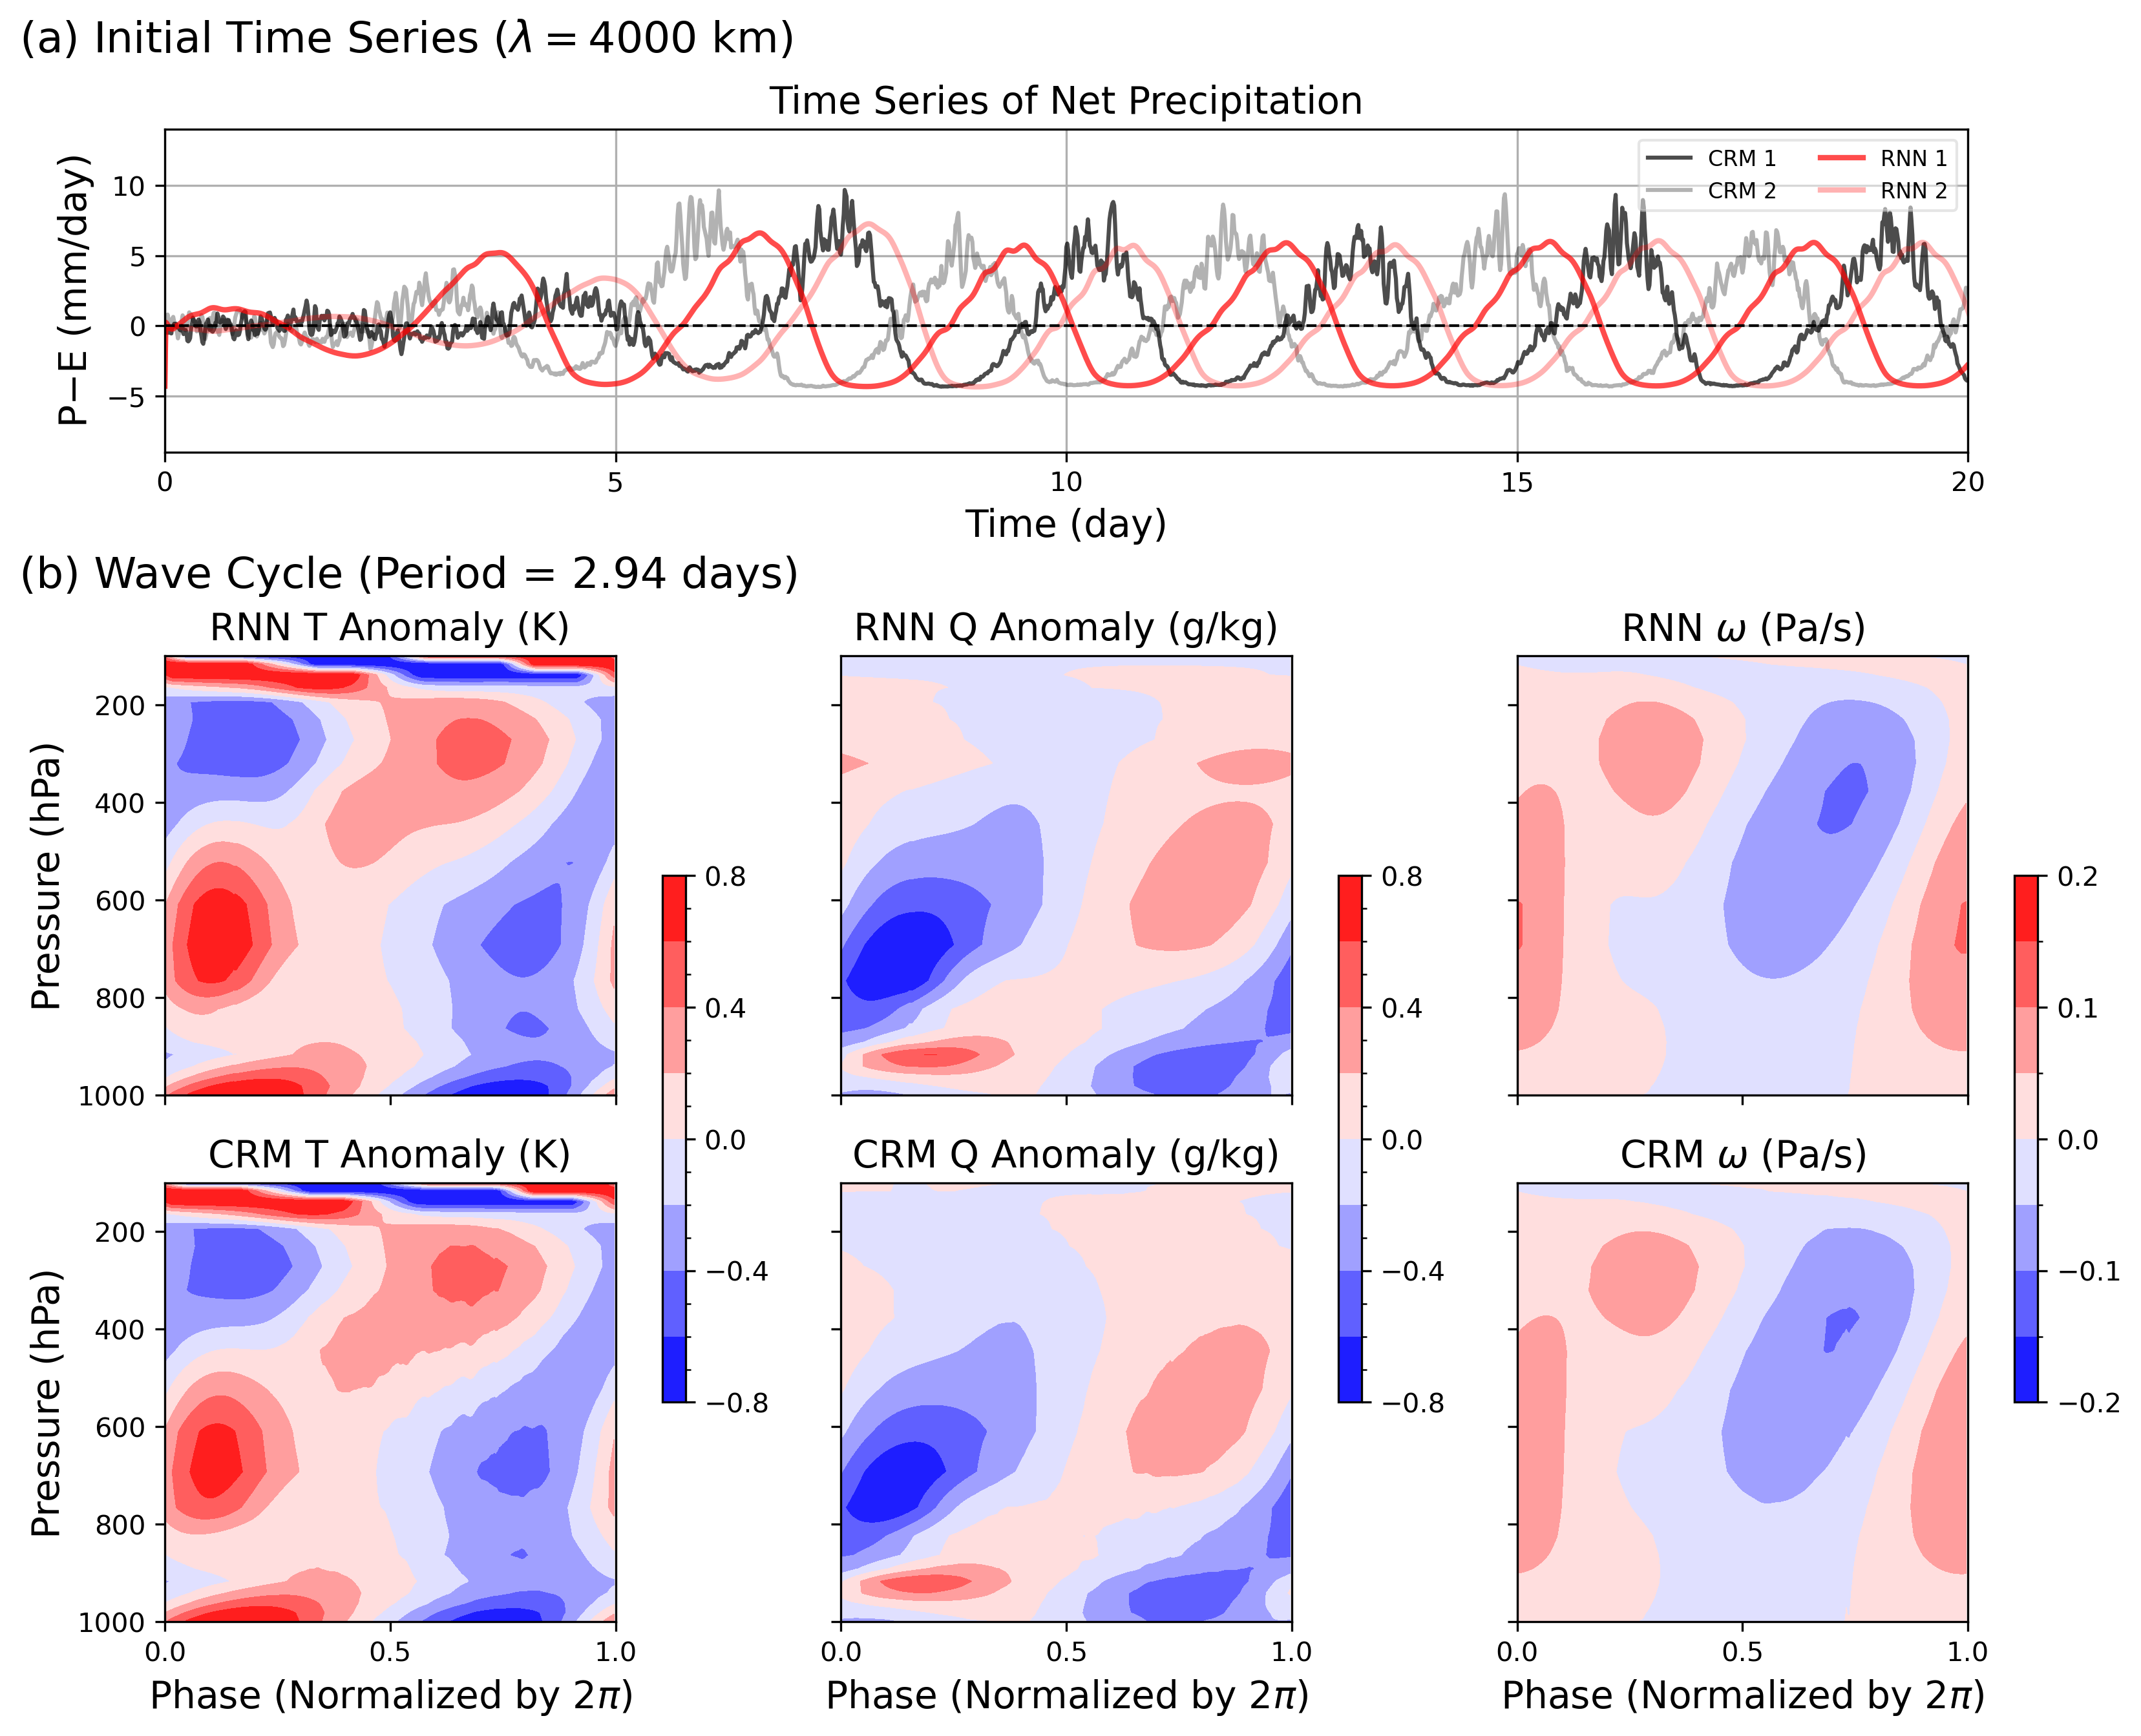

In [6]:
wn = 10
damp = 2

fig = plt.figure(figsize=(12, 10), dpi=300)
gs = fig.add_gridspec(ncols=3, nrows=3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, :])
SAMdata = nc.Dataset(f'../data/RCE_noisywave_wn{wn}_damp{damp}day_noadvectbg_noiselevel_0.0_1_1.nc', 'r')
time = SAMdata['time'][:]
time = time - time[0]
SAM_p = SAMdata['PREC'][:]
SAM_e = SAMdata['LHF'][:] / 2.5e6 * 86400
SAM_p = SAM_p - SAM_e
ax1.plot(time, SAM_p, label='CRM 1', color='k', alpha=0.7)

SAMdata = nc.Dataset(f'../data/RCE_noisywave_wn{wn}_damp{damp}day_noadvectbg_noiselevel_0.0_2_1.nc', 'r')
SAM_p = SAMdata['PREC'][:]
SAM_e = SAMdata['LHF'][:] / 2.5e6 * 86400
SAM_p = SAM_p - SAM_e
ax1.plot(time, SAM_p, label='CRM 2', color='k', alpha=0.3)

params, grd_var, results = test_model(wavenumber_factor=wn/40., wavedamping_time=damp, nday=20)
RNN_p = results['precout']
delq = spinup_Q[:, 0].mean()/1000. + results['qout'][0, :] / 1000. - ssq
cd = 1.1e-3
windspeed = 5.
wrk = (np.log(10/1.e-4) / np.log(spinup_dataset['z'][0]/1.e-4))**2
evap_diag = -cd*windspeed*delq*wrk * 86400 * 1.173
ax1.plot(grd_var['time'], results['iprecout_ml'] - evap_diag, label='RNN 1', color='r', linewidth=2, alpha=0.7)

params, grd_var, results = test_model(wavenumber_factor=wn/40., wavedamping_time=damp, nday=100)
RNN_p = results['precout']
delq = spinup_Q[:, 0].mean()/1000. + results['qout'][0, :] / 1000. - ssq
evap_diag = -cd*windspeed*delq*wrk * 86400 * 1.173
ax1.plot(grd_var['time'], results['iprecout_ml'] - evap_diag, label='RNN 2', color='r', linewidth=2, alpha=0.3)
ax1.axhline(y=0, linestyle='--', color='k', linewidth=1)
ax1.set_xlabel('Time (day)', fontsize=14)
ax1.set_ylabel(r'P$-$E (mm/day)', fontsize=14)
ax1.set_title(f'Time Series of Net Precipitation', fontsize=14)
ax1.grid()
ax1.legend(loc='upper right', ncol=2, fontsize=8, framealpha=0.5)
ax1.set_xlim(0, 20)
ax1.set_ylim(-9, 14)
ax1.set_xticks(np.arange(0, 25, 5))
ax1.set_yticks(np.arange(-5, 15, 5))

SAMdata = nc.Dataset(f'../data/RCE_noisywave_wn{wn}_damp{damp}day_noadvectbg_noiselevel_0.0_2_2.nc', 'r')
# determine shift
SAMshift = 0
RNNshift = 0
SAM_w = SAMdata['W_WAVE'][0*96:50*96, :]
data_filtered, ind = extract_cycle(SAM_w)
SAM_nstep_plot = int(50 / ind * 96)
data_tmp = data_filtered[10, :SAM_nstep_plot]
SAMshift = np.argmin(data_tmp)
print(SAMshift, SAM_nstep_plot)
data_filtered, ind = extract_cycle(results['wout'][:26, 50*96:100*96].transpose() / grd_var['rho'][:26] / (-10.))
RNN_nstep_plot = int(50 / ind * 96)
data_tmp = data_filtered[10, :RNN_nstep_plot]
RNNshift = np.argmin(data_tmp)
print(RNNshift, RNN_nstep_plot)

ax_t_rnn = fig.add_subplot(gs[1, 0])
ax_t_sam = fig.add_subplot(gs[2, 0])
ax_q_rnn = fig.add_subplot(gs[1, 1])
ax_q_sam = fig.add_subplot(gs[2, 1])
ax_w_rnn = fig.add_subplot(gs[1, 2])
ax_w_sam = fig.add_subplot(gs[2, 2])
fig.subplots_adjust(wspace=0.5)
SAM_tanom = SAMdata['T_WAVE'][0*96:50*96, :] - SAMdata['T_WAVEBG'][0*96:50*96, :]
data_filtered, ind = extract_cycle(SAM_tanom)
data_filtered[data_filtered>0.8] = 0.8
data_filtered[data_filtered<-0.8] = -0.8
SAM_nstep_plot = int(50 / ind * 96)
cplot = ax_t_sam.contourf(time[:SAM_nstep_plot] / time[SAM_nstep_plot], grd_var['pres'][:26],
                          data_filtered[:26, SAMshift:SAMshift+SAM_nstep_plot], levels=np.linspace(-0.8, 0.8, 9),
                          cmap='bwr', vmax=0.8, vmin=-0.8)
data_filtered, ind = extract_cycle(results['tout'][:26, 50*96:100*96].transpose())
data_filtered[data_filtered>0.8] = 0.8
data_filtered[data_filtered<-0.8] = -0.8
RNN_nstep_plot = int(50 / ind * 96)
ax_t_rnn.contourf(time[:RNN_nstep_plot] / time[RNN_nstep_plot], grd_var['pres'][:26],
                  data_filtered[:26, RNNshift:RNNshift+RNN_nstep_plot], levels=np.linspace(-0.8, 0.8, 9),
                  cmap='bwr', vmax=0.8, vmin=-0.8)
pos_up = ax_t_rnn.get_position()
pos_down = ax_t_sam.get_position()
cax = plt.axes([pos_up.x1+0.02, pos_down.y0+0.5*pos_down.height, 0.01, pos_up.y0-pos_down.y0])
cbar = fig.colorbar(cplot, cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-0.8, 0.8, 5))
cbar.ax.minorticks_on()


SAM_qanom = SAMdata['Q_WAVE'][0*96:50*96, :] - SAMdata['Q_WAVEBG'][0*96:50*96, :]
data_filtered, _ = extract_cycle(SAM_qanom)
cplot = ax_q_sam.contourf(time[:SAM_nstep_plot] / time[SAM_nstep_plot], grd_var['pres'][:26],
                          data_filtered[:26, SAMshift:SAMshift+SAM_nstep_plot], levels=np.linspace(-0.8, 0.8, 9),
                          cmap='bwr', vmax=0.8, vmin=-0.8)
data_filtered, _ = extract_cycle(results['qout'][:26, 50*96:100*96].transpose())
data_filtered[data_filtered>0.8] = 0.8
data_filtered[data_filtered<-0.8] = -0.8
ax_q_rnn.contourf(time[:RNN_nstep_plot] / time[RNN_nstep_plot], grd_var['pres'][:26],
                  data_filtered[:26, RNNshift:RNNshift+RNN_nstep_plot], levels=np.linspace(-0.8, 0.8, 9),
                  cmap='bwr', vmax=0.8, vmin=-0.8)
pos_up = ax_q_rnn.get_position()
pos_down = ax_q_sam.get_position()
cax = plt.axes([pos_up.x1+0.02, pos_down.y0+0.5*pos_down.height, 0.01, pos_up.y0-pos_down.y0])
cbar = fig.colorbar(cplot, cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-0.8, 0.8, 5))
cbar.ax.minorticks_on()


SAM_w = SAMdata['W_WAVE'][0*96:50*96, :] * grd_var['rho'][np.newaxis, :] * (-10)
data_filtered, _ = extract_cycle(SAM_w)
cplot = ax_w_sam.contourf(time[:SAM_nstep_plot] / time[SAM_nstep_plot], grd_var['pres'][:26],
                          data_filtered[:26, SAMshift:SAMshift+SAM_nstep_plot], levels=np.linspace(-0.2, 0.2, 9),
                          cmap='bwr')
data_filtered, _ = extract_cycle(results['wout'][:26, 50*96:100*96].transpose())
ax_w_rnn.contourf(time[:RNN_nstep_plot] / time[RNN_nstep_plot], grd_var['pres'][:26],
                  data_filtered[:26, RNNshift:RNNshift+RNN_nstep_plot], levels=np.linspace(-0.2, 0.2, 9),
                  cmap='bwr')
pos_up = ax_w_rnn.get_position()
pos_down = ax_w_sam.get_position()
cax = plt.axes([pos_up.x1+0.02, pos_down.y0+0.5*pos_down.height, 0.01, pos_up.y0-pos_down.y0])
cbar = fig.colorbar(cplot, cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-0.2, 0.2, 5))
cbar.ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))

ax_t_rnn.set_ylim(1000, 100)
ax_t_sam.set_ylim(1000, 100)
ax_q_rnn.set_ylim(1000, 100)
ax_q_sam.set_ylim(1000, 100)
ax_w_rnn.set_ylim(1000, 100)
ax_w_sam.set_ylim(1000, 100)
for ax in [ax_t_rnn, ax_q_rnn, ax_w_rnn]:
    ax.set_xticklabels([])

for ax in [ax_q_rnn, ax_q_sam, ax_w_rnn, ax_w_sam]:
    ax.set_yticklabels([])
ax_t_sam.set_ylabel('Pressure (hPa)', fontsize=14)
ax_t_rnn.set_ylabel('Pressure (hPa)', fontsize=14)
ax_t_rnn.set_xticks([0, 0.5, 1])
ax_q_rnn.set_xticks([0, 0.5, 1])
ax_w_rnn.set_xticks([0, 0.5, 1])
ax_t_sam.set_xticks([0, 0.5, 1])
ax_q_sam.set_xticks([0, 0.5, 1])
ax_w_sam.set_xticks([0, 0.5, 1])
ax_t_sam.set_xlabel(r'Phase (Normalized by 2$\pi$)', fontsize=14)
ax_q_sam.set_xlabel(r'Phase (Normalized by 2$\pi$)', fontsize=14)
ax_w_sam.set_xlabel(r'Phase (Normalized by 2$\pi$)', fontsize=14)
ax_t_rnn.set_title('RNN T Anomaly (K)', fontsize=14)
ax_t_sam.set_title('CRM T Anomaly (K)', fontsize=14)
ax_q_rnn.set_title('RNN Q Anomaly (g/kg)', fontsize=14)
ax_q_sam.set_title('CRM Q Anomaly (g/kg)', fontsize=14)
ax_w_rnn.set_title(r'RNN $\omega$ (Pa/s)', fontsize=14)
ax_w_sam.set_title(r'CRM $\omega$ (Pa/s)', fontsize=14)

pos1 = ax1.get_position()  # Get the current position of the first subplot
new_pos1 = [pos1.x0, pos1.y0 + 0.06, pos1.width, pos1.height - 0.06]  # Adjust position
ax1.set_position(new_pos1)
fig.text(pos1.x0/2, 0.92, '(a) Initial Time Series '+r'($\lambda=4000$ km)', ha='left', fontsize=16)
period = str(round(time[SAM_nstep_plot], 2))
print(period)
fig.text(pos1.x0/2, pos1.y0-0.01, f'(b) Wave Cycle (Period = {period} days)', ha='left', fontsize=16)
plt.show()

### Time series and wave cycle comparison for 2000-km wave (Figure S1)

Loading grid variables...
Loading model parameters...
(64, 64)
(64, 40)
(41, 64)
Initializing outputs...
Initializing states...
Starting intergration...
Model run finished...
Integrating results...
Loading grid variables...
Loading model parameters...
(64, 64)
(64, 40)
(41, 64)
Initializing outputs...
Initializing states...
Starting intergration...
Model run finished...
Integrating results...
38 141
11 137
1.47


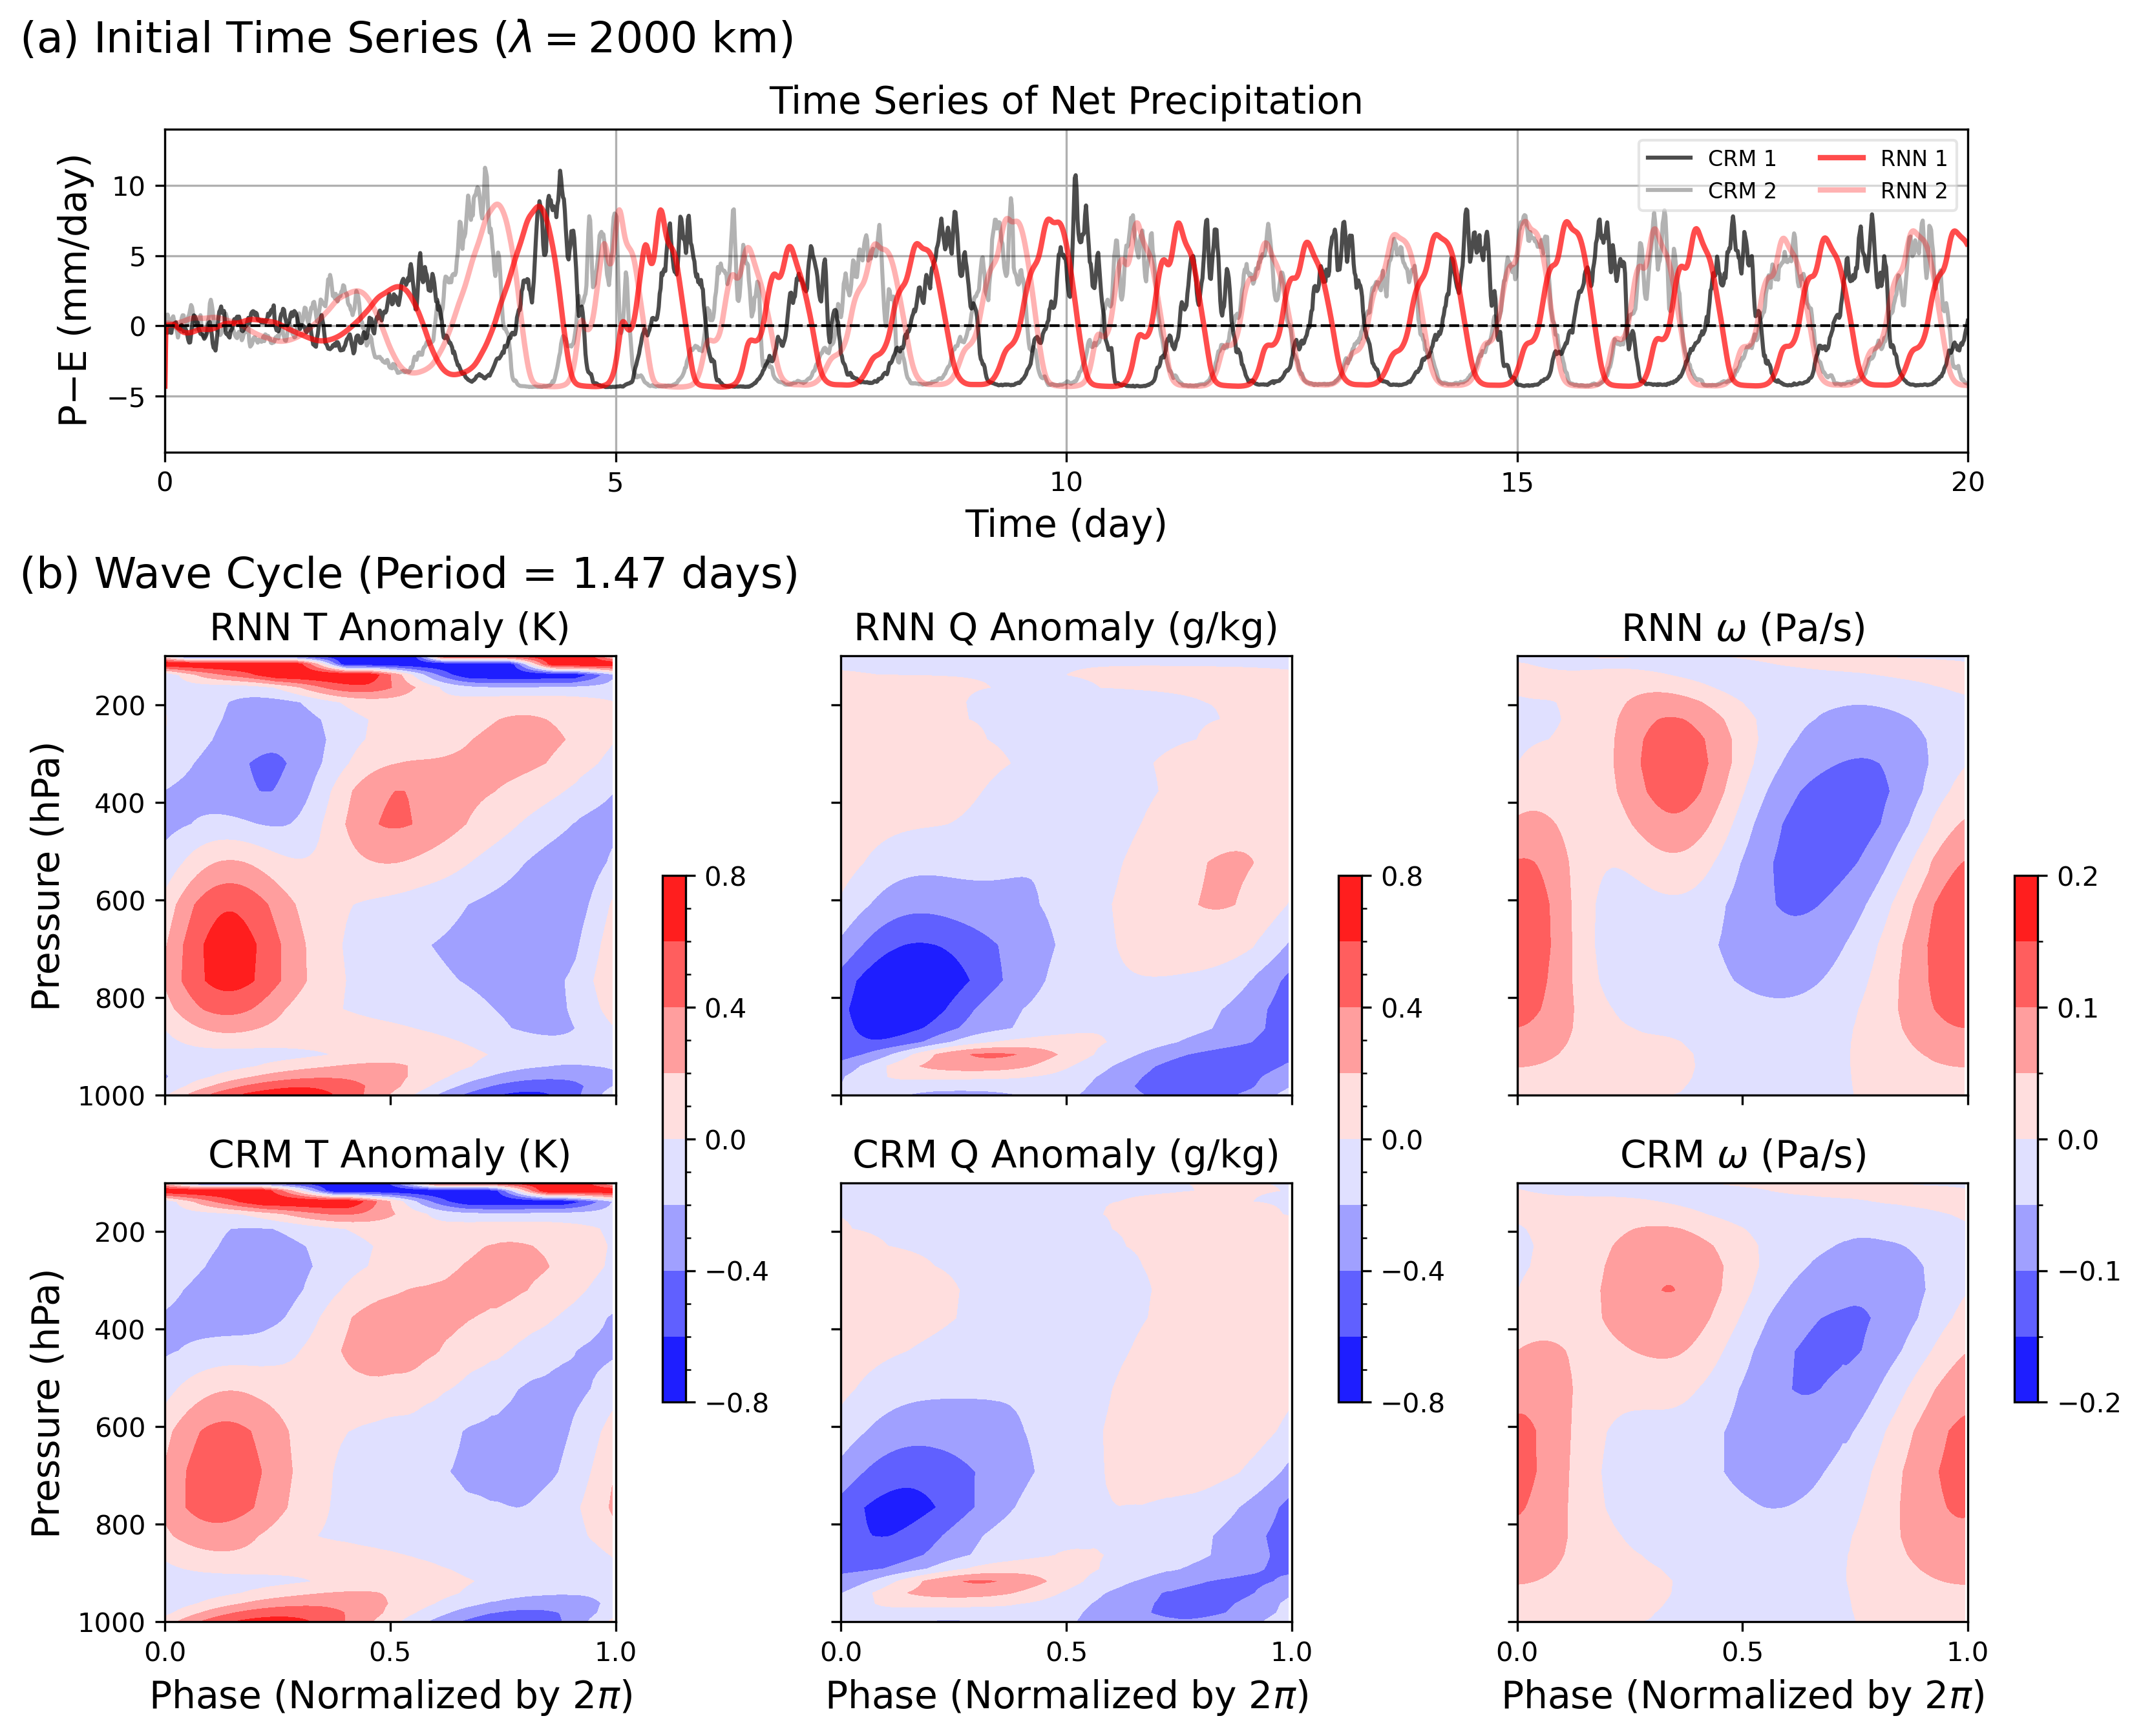

In [7]:
wn = 20
damp = 2

fig = plt.figure(figsize=(12, 10), dpi=300)
gs = fig.add_gridspec(ncols=3, nrows=3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, :])
SAMdata = nc.Dataset(f'../data/RCE_noisywave_wn{wn}_damp{damp}day_noadvectbg_noiselevel_0.0_1_1.nc', 'r')
time = SAMdata['time'][:]
time = time - time[0]
SAM_p = SAMdata['PREC'][:]
SAM_e = SAMdata['LHF'][:] / 2.5e6 * 86400
SAM_p = SAM_p - SAM_e
ax1.plot(time, SAM_p, label='CRM 1', color='k', alpha=0.7)

SAMdata = nc.Dataset(f'../data/RCE_noisywave_wn{wn}_damp{damp}day_noadvectbg_noiselevel_0.0_2_1.nc', 'r')
SAM_p = SAMdata['PREC'][:]
SAM_e = SAMdata['LHF'][:] / 2.5e6 * 86400
SAM_p = SAM_p - SAM_e
ax1.plot(time, SAM_p, label='CRM 2', color='k', alpha=0.3)

params, grd_var, results = test_model(wavenumber_factor=wn/40., wavedamping_time=damp, nday=20)
RNN_p = results['precout']
delq = spinup_Q[:, 0].mean()/1000. + results['qout'][0, :] / 1000. - ssq
cd = 1.1e-3
windspeed = 5.
wrk = (np.log(10/1.e-4) / np.log(spinup_dataset['z'][0]/1.e-4))**2
evap_diag = -cd*windspeed*delq*wrk * 86400 * 1.173
ax1.plot(grd_var['time'], results['iprecout_ml'] - evap_diag, label='RNN 1', color='r', linewidth=2, alpha=0.7)

params, grd_var, results = test_model(wavenumber_factor=wn/40., wavedamping_time=damp, nday=100)
RNN_p = results['precout']
delq = spinup_Q[:, 0].mean()/1000. + results['qout'][0, :] / 1000. - ssq
evap_diag = -cd*windspeed*delq*wrk * 86400 * 1.173
ax1.plot(grd_var['time'], results['iprecout_ml'] - evap_diag, label='RNN 2', color='r', linewidth=2, alpha=0.3)
ax1.axhline(y=0, linestyle='--', color='k', linewidth=1)
ax1.set_xlabel('Time (day)', fontsize=14)
ax1.set_ylabel(r'P$-$E (mm/day)', fontsize=14)
ax1.set_title(f'Time Series of Net Precipitation', fontsize=14)
ax1.grid()
ax1.legend(loc='upper right', ncol=2, fontsize=8, framealpha=0.5)
ax1.set_xlim(0, 20)
ax1.set_ylim(-9, 14)
ax1.set_xticks(np.arange(0, 25, 5))
ax1.set_yticks(np.arange(-5, 15, 5))

SAMdata = nc.Dataset(f'../data/RCE_noisywave_wn{wn}_damp{damp}day_noadvectbg_noiselevel_0.0_2_2.nc', 'r')
# determine shift
SAMshift = 0
RNNshift = 0
SAM_w = SAMdata['W_WAVE'][0*96:50*96, :]
data_filtered, ind = extract_cycle(SAM_w)
SAM_nstep_plot = int(50 / ind * 96)
data_tmp = data_filtered[10, :SAM_nstep_plot]
SAMshift = np.argmin(data_tmp)
print(SAMshift, SAM_nstep_plot)
data_filtered, ind = extract_cycle(results['wout'][:26, 50*96:100*96].transpose() / grd_var['rho'][:26] / (-10.))
RNN_nstep_plot = int(50 / ind * 96)
data_tmp = data_filtered[10, :RNN_nstep_plot]
RNNshift = np.argmin(data_tmp)
print(RNNshift, RNN_nstep_plot)

ax_t_rnn = fig.add_subplot(gs[1, 0])
ax_t_sam = fig.add_subplot(gs[2, 0])
ax_q_rnn = fig.add_subplot(gs[1, 1])
ax_q_sam = fig.add_subplot(gs[2, 1])
ax_w_rnn = fig.add_subplot(gs[1, 2])
ax_w_sam = fig.add_subplot(gs[2, 2])
fig.subplots_adjust(wspace=0.5)
SAM_tanom = SAMdata['T_WAVE'][0*96:50*96, :] - SAMdata['T_WAVEBG'][0*96:50*96, :]
data_filtered, ind = extract_cycle(SAM_tanom)
data_filtered[data_filtered>0.8] = 0.8
data_filtered[data_filtered<-0.8] = -0.8
SAM_nstep_plot = int(50 / ind * 96)
cplot = ax_t_sam.contourf(time[:SAM_nstep_plot] / time[SAM_nstep_plot], grd_var['pres'][:26],
                          data_filtered[:26, SAMshift:SAMshift+SAM_nstep_plot], levels=np.linspace(-0.8, 0.8, 9),
                          cmap='bwr', vmax=0.8, vmin=-0.8)
data_filtered, ind = extract_cycle(results['tout'][:26, 50*96:100*96].transpose())
data_filtered[data_filtered>0.8] = 0.8
data_filtered[data_filtered<-0.8] = -0.8
RNN_nstep_plot = int(50 / ind * 96)
ax_t_rnn.contourf(time[:RNN_nstep_plot] / time[RNN_nstep_plot], grd_var['pres'][:26],
                  data_filtered[:26, RNNshift:RNNshift+RNN_nstep_plot], levels=np.linspace(-0.8, 0.8, 9),
                  cmap='bwr', vmax=0.8, vmin=-0.8)
pos_up = ax_t_rnn.get_position()
pos_down = ax_t_sam.get_position()
cax = plt.axes([pos_up.x1+0.02, pos_down.y0+0.5*pos_down.height, 0.01, pos_up.y0-pos_down.y0])
cbar = fig.colorbar(cplot, cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-0.8, 0.8, 5))
cbar.ax.minorticks_on()


SAM_qanom = SAMdata['Q_WAVE'][0*96:50*96, :] - SAMdata['Q_WAVEBG'][0*96:50*96, :]
data_filtered, _ = extract_cycle(SAM_qanom)
cplot = ax_q_sam.contourf(time[:SAM_nstep_plot] / time[SAM_nstep_plot], grd_var['pres'][:26],
                          data_filtered[:26, SAMshift:SAMshift+SAM_nstep_plot], levels=np.linspace(-0.8, 0.8, 9),
                          cmap='bwr', vmax=0.8, vmin=-0.8)
data_filtered, _ = extract_cycle(results['qout'][:26, 50*96:100*96].transpose())
data_filtered[data_filtered>0.8] = 0.8
data_filtered[data_filtered<-0.8] = -0.8
ax_q_rnn.contourf(time[:RNN_nstep_plot] / time[RNN_nstep_plot], grd_var['pres'][:26],
                  data_filtered[:26, RNNshift:RNNshift+RNN_nstep_plot], levels=np.linspace(-0.8, 0.8, 9),
                  cmap='bwr', vmax=0.8, vmin=-0.8)
pos_up = ax_q_rnn.get_position()
pos_down = ax_q_sam.get_position()
cax = plt.axes([pos_up.x1+0.02, pos_down.y0+0.5*pos_down.height, 0.01, pos_up.y0-pos_down.y0])
cbar = fig.colorbar(cplot, cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-0.8, 0.8, 5))
cbar.ax.minorticks_on()


SAM_w = SAMdata['W_WAVE'][0*96:50*96, :] * grd_var['rho'][np.newaxis, :] * (-10)
data_filtered, _ = extract_cycle(SAM_w)
cplot = ax_w_sam.contourf(time[:SAM_nstep_plot] / time[SAM_nstep_plot], grd_var['pres'][:26],
                          data_filtered[:26, SAMshift:SAMshift+SAM_nstep_plot], levels=np.linspace(-0.2, 0.2, 9),
                          cmap='bwr')
data_filtered, _ = extract_cycle(results['wout'][:26, 50*96:100*96].transpose())
ax_w_rnn.contourf(time[:RNN_nstep_plot] / time[RNN_nstep_plot], grd_var['pres'][:26],
                  data_filtered[:26, RNNshift:RNNshift+RNN_nstep_plot], levels=np.linspace(-0.2, 0.2, 9),
                  cmap='bwr')
pos_up = ax_w_rnn.get_position()
pos_down = ax_w_sam.get_position()
cax = plt.axes([pos_up.x1+0.02, pos_down.y0+0.5*pos_down.height, 0.01, pos_up.y0-pos_down.y0])
cbar = fig.colorbar(cplot, cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-0.2, 0.2, 5))
cbar.ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))

ax_t_rnn.set_ylim(1000, 100)
ax_t_sam.set_ylim(1000, 100)
ax_q_rnn.set_ylim(1000, 100)
ax_q_sam.set_ylim(1000, 100)
ax_w_rnn.set_ylim(1000, 100)
ax_w_sam.set_ylim(1000, 100)
for ax in [ax_t_rnn, ax_q_rnn, ax_w_rnn]:
    ax.set_xticklabels([])

for ax in [ax_q_rnn, ax_q_sam, ax_w_rnn, ax_w_sam]:
    ax.set_yticklabels([])
ax_t_sam.set_ylabel('Pressure (hPa)', fontsize=14)
ax_t_rnn.set_ylabel('Pressure (hPa)', fontsize=14)
ax_t_rnn.set_xticks([0, 0.5, 1])
ax_q_rnn.set_xticks([0, 0.5, 1])
ax_w_rnn.set_xticks([0, 0.5, 1])
ax_t_sam.set_xticks([0, 0.5, 1])
ax_q_sam.set_xticks([0, 0.5, 1])
ax_w_sam.set_xticks([0, 0.5, 1])
ax_t_sam.set_xlabel(r'Phase (Normalized by 2$\pi$)', fontsize=14)
ax_q_sam.set_xlabel(r'Phase (Normalized by 2$\pi$)', fontsize=14)
ax_w_sam.set_xlabel(r'Phase (Normalized by 2$\pi$)', fontsize=14)
ax_t_rnn.set_title('RNN T Anomaly (K)', fontsize=14)
ax_t_sam.set_title('CRM T Anomaly (K)', fontsize=14)
ax_q_rnn.set_title('RNN Q Anomaly (g/kg)', fontsize=14)
ax_q_sam.set_title('CRM Q Anomaly (g/kg)', fontsize=14)
ax_w_rnn.set_title(r'RNN $\omega$ (Pa/s)', fontsize=14)
ax_w_sam.set_title(r'CRM $\omega$ (Pa/s)', fontsize=14)

pos1 = ax1.get_position()  # Get the current position of the first subplot
new_pos1 = [pos1.x0, pos1.y0 + 0.06, pos1.width, pos1.height - 0.06]  # Adjust position
ax1.set_position(new_pos1)
fig.text(pos1.x0/2, 0.92, '(a) Initial Time Series '+r'($\lambda=2000$ km)', ha='left', fontsize=16)
period = str(round(time[SAM_nstep_plot], 2))
print(period)
fig.text(pos1.x0/2, pos1.y0-0.01, f'(b) Wave Cycle (Period = {period} days)', ha='left', fontsize=16)
plt.show()

### Calculate linear impulse response

In [8]:
linear_params = load_params()
A = linear_params['A']
B = linear_params['B']
C = linear_params['C']
mass_weight = linear_params['mass_weight']

loadmodel = 'epoch=4579-val_loss=0.095.ckpt'
checkpoint = torch.load(loadmodel, map_location=torch.device('cpu'))
nonlinear_params = checkpoint['state_dict']
qg0 = grd_var['q_wavebg']

dp = np.zeros(26)
dp[1:] = (grd_var['pres'][2:27] - grd_var['pres'][:25])/2
dp[0] = grd_var['pres'][1] - grd_var['pres'][0]
dp *= -1
nT=26
nQ=14

(64, 64)
(64, 40)
(41, 64)


In [9]:
wn = 20
damp = 2
params, grd_var, results = test_model(wavenumber_factor=wn/40., wavedamping_time=damp, nday=50)

Loading grid variables...
Loading model parameters...
(64, 64)
(64, 40)
(41, 64)
Initializing outputs...
Initializing states...
Starting intergration...
Model run finished...
Integrating results...


In [10]:
def dfdx(nonlinear_params, x0=np.zeros((64, 1)), i0=np.zeros((40, 1))):
    tmp = np.zeros((64, 64))
    scale = 1e-2
    for i in range(64):
        x_ = copy.deepcopy(x0)
        x_[i, 0] += scale
        diff = input_layer_nonlinear(nonlinear_params, x_, i0) - input_layer_nonlinear(nonlinear_params, x0, i0)
        tmp[:, i] = diff[:, 0] / scale
    return tmp

def dfdi(nonlinear_params, x0=np.zeros((64, 1)), i0=np.zeros((40, 1))):
    tmp = np.zeros((64, 40))
    scale = 1e-2
    for i in range(40):
        i_ = copy.deepcopy(i0)
        i_[i, 0] += scale
        diff = input_layer_nonlinear(nonlinear_params, x0, i_) - input_layer_nonlinear(nonlinear_params, x0, i0)
        tmp[:, i] = diff[:, 0] / scale
    return tmp

In [11]:
netP_tmp = results['iprecout_ml'][41*96:44*96] - evap_diag[41*96:44*96]
P_tmp = results['iprecout_ml'][41*96:44*96]
ind_min = np.argmin(netP_tmp)
ind_max = np.argmax(netP_tmp)

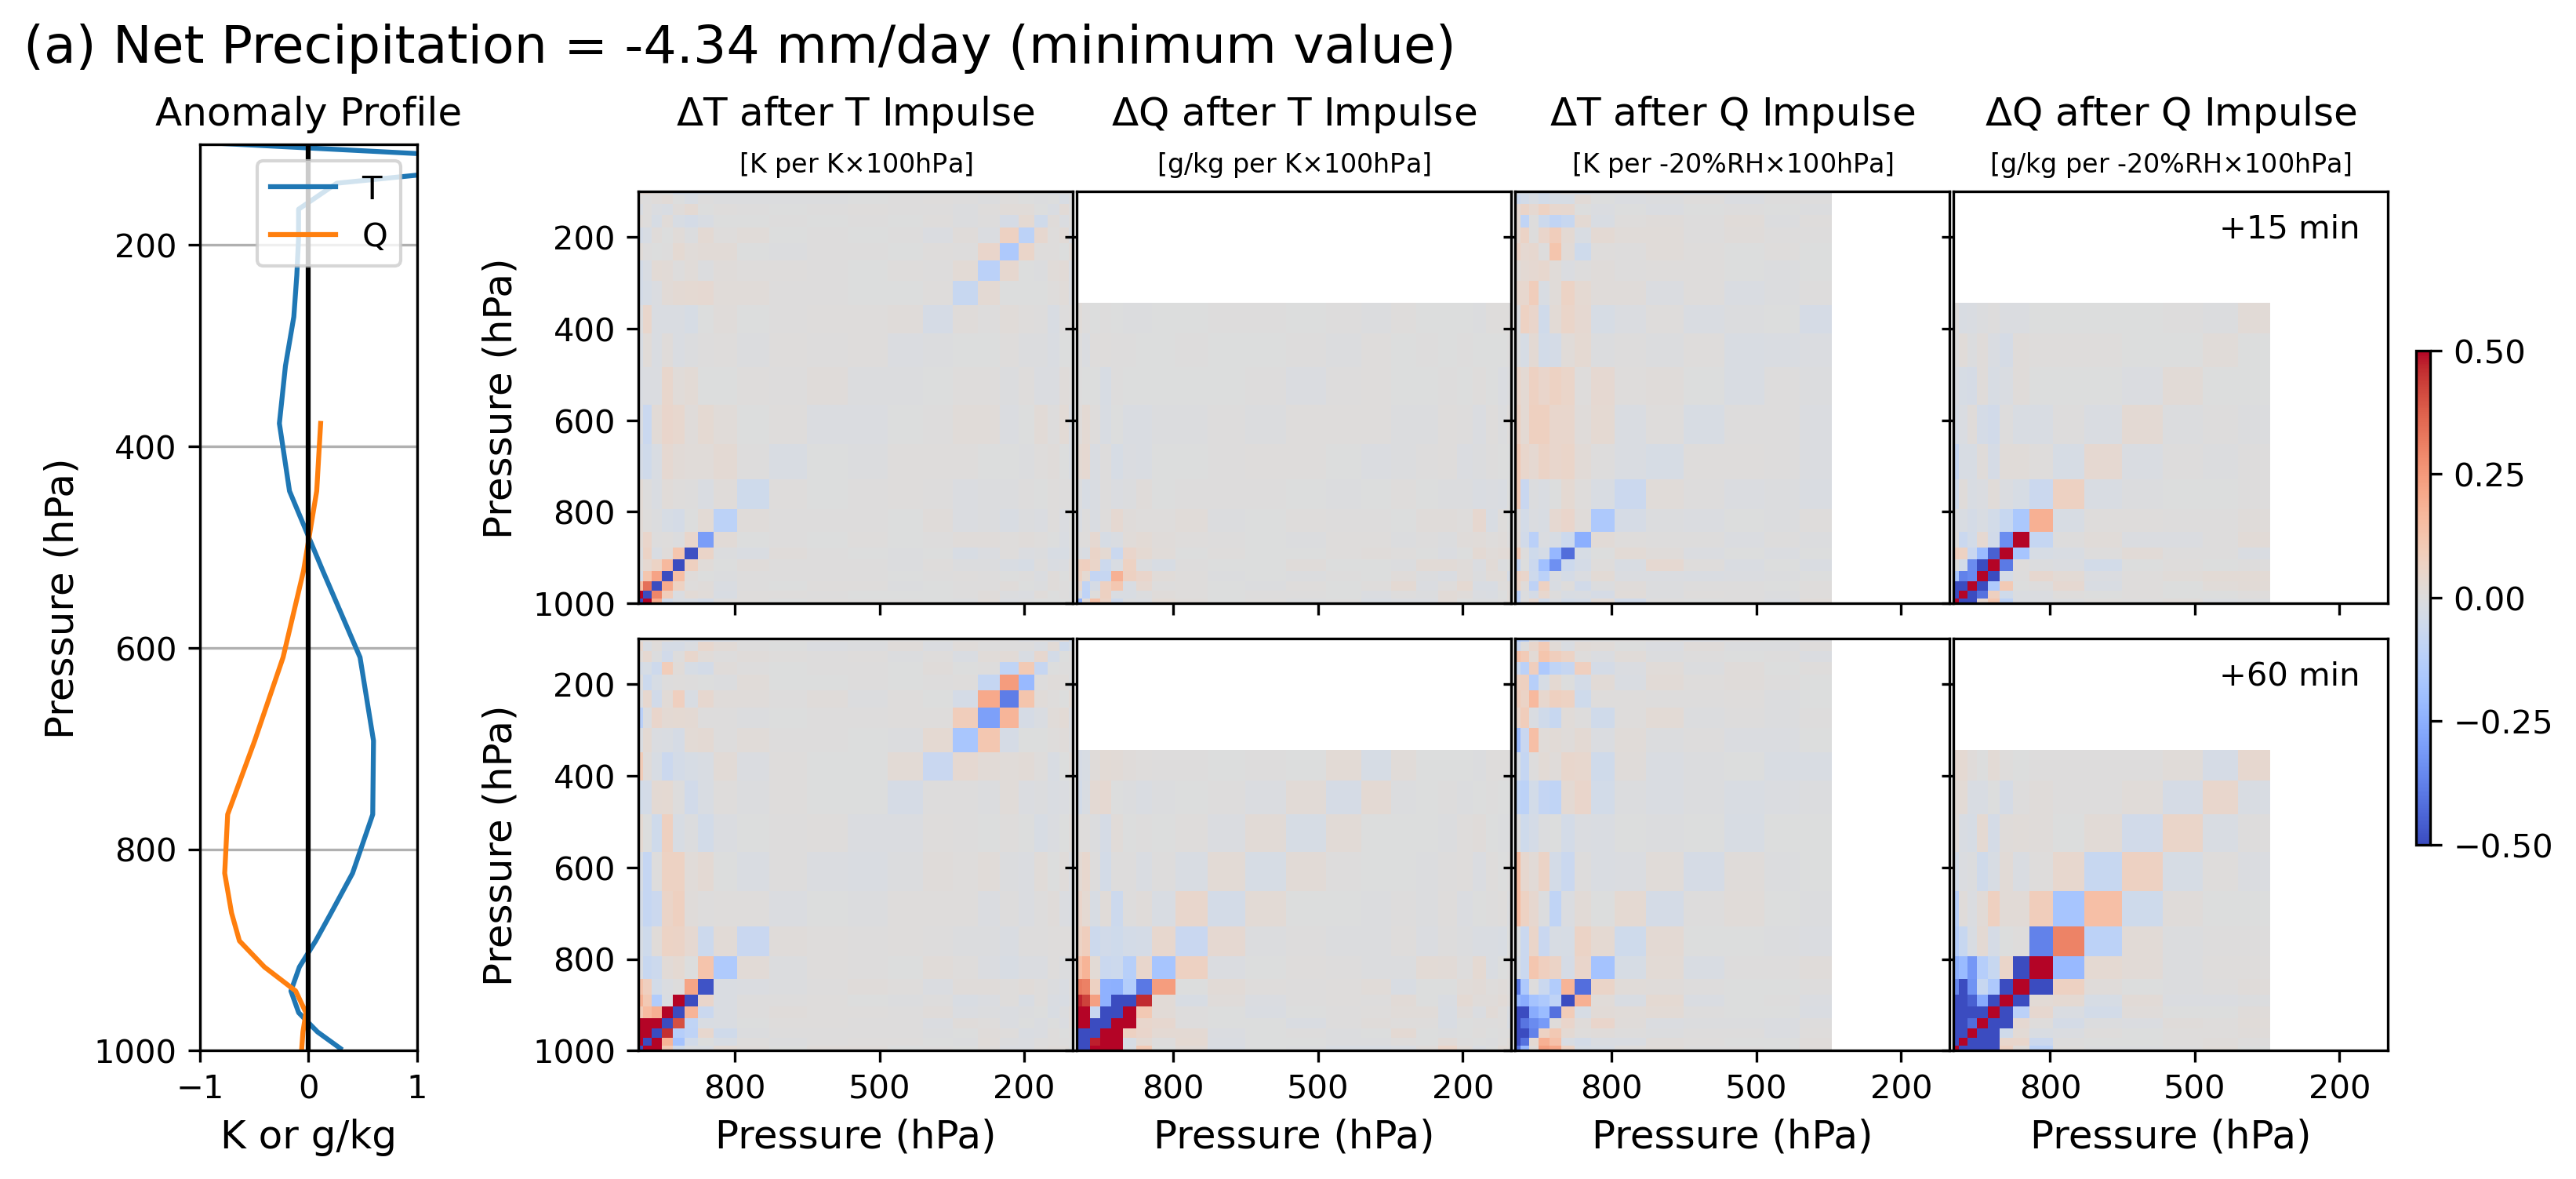

In [12]:
istep = 41*96+ind_min
i0 = results['iout'][:, istep:istep+1]
x0 = results['xout'][:, istep-1:istep]
Ap = A + dfdx(nonlinear_params, x0=x0, i0=i0)
tmp = np.linalg.solve(mass_weight, C)[:40, :64] @ (B @ mass_weight[:40, :40] + dfdi(nonlinear_params, x0=x0, i0=i0) @ mass_weight[:40, :40]) - np.identity(40)
for i in range(26):
    tmp[:, i] *= (100 / dp[i])
for i in range(14):
    tmp[:, i+26] *= -qg0[i] * 0.2 * (100 / dp[i])
    
fig = plt.figure(figsize=(12, 5), dpi=300)
gs = fig.add_gridspec(ncols=5, nrows=2, width_ratios=[1, 1, 1, 1, 1], height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax1.plot(results['tout'][:26, istep], grd_var['pres'][:26], label='T')
ax1.plot(results['qout'][:14, istep], grd_var['pres'][:14], label='Q')
ax1.legend(loc='upper right')
ax1.grid()
ax1.axvline(x=0, color='k')
ax1.set_ylim(1000, 100)
ax1.set_xlim(-1, 1)
ax1.set_title('Anomaly Profile', fontsize=12)

fig.subplots_adjust(wspace=0.01)
ax_tt1 = fig.add_subplot(gs[0, 1])
ax_qt1 = fig.add_subplot(gs[0, 2])
ax_tq1 = fig.add_subplot(gs[0, 3])
ax_qq1 = fig.add_subplot(gs[0, 4])
ax_tt2 = fig.add_subplot(gs[1, 1])
ax_qt2 = fig.add_subplot(gs[1, 2])
ax_tq2 = fig.add_subplot(gs[1, 3])
ax_qq2 = fig.add_subplot(gs[1, 4])

cmap = 'coolwarm'
cax0 = ax_tt1.pcolormesh(grd_var['pres'][:26], grd_var['pres'][:26], tmp[:26, :26], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_tt1.set_xlim(1000, 100)
ax_tt1.set_ylim(1000, 100)
ax_tt1.set_title(r'[K per K$\times$100hPa]', fontsize=8)

cax1 = ax_qt1.pcolormesh(grd_var['pres'][:26], grd_var['pres'][:14], tmp[26:40, :26], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_qt1.set_xlim(1000, 100)
ax_qt1.set_ylim(1000, 100)
ax_qt1.set_title(r'[g/kg per K$\times$100hPa]', fontsize=8)

cax2 = ax_tq1.pcolormesh(grd_var['pres'][:14], grd_var['pres'][:26], tmp[:26, 26:40], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_tq1.set_xlim(1000, 100)
ax_tq1.set_ylim(1000, 100)
ax_tq1.set_title(r'[K per -20%RH$\times$100hPa]', fontsize=8)

cax3 = ax_qq1.pcolormesh(grd_var['pres'][:14], grd_var['pres'][:14], tmp[26:40, 26:40], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_qq1.set_xlim(1000, 100)
ax_qq1.set_ylim(1000, 100)
ax_qq1.set_title(r'[g/kg per -20%RH$\times$100hPa]', fontsize=8)

tmp = np.linalg.solve(mass_weight, C)[:40, :64] @ Ap @ Ap @ Ap @ (B @ mass_weight[:40, :40] + dfdi(nonlinear_params, x0=x0, i0=i0) @ mass_weight[:40, :40]) - np.identity(40)
for i in range(26):
    tmp[:, i] *= (100 / dp[i])
for i in range(14):
    tmp[:, i+26] *= -qg0[i] * 0.2 * (100 / dp[i])
cax0 = ax_tt2.pcolormesh(grd_var['pres'][:26], grd_var['pres'][:26], tmp[:26, :26], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_tt2.set_xlim(1000, 100)
ax_tt2.set_ylim(1000, 100)
#ax_tt2.set_title(r'$\Delta$T from dT/dt', fontsize=14)

cax1 = ax_qt2.pcolormesh(grd_var['pres'][:26], grd_var['pres'][:14], tmp[26:40, :26], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_qt2.set_xlim(1000, 100)
ax_qt2.set_ylim(1000, 100)
#ax_qt2.set_title(r'$\Delta$Q from dT/dt', fontsize=14)

cax2 = ax_tq2.pcolormesh(grd_var['pres'][:14], grd_var['pres'][:26], tmp[:26, 26:40], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_tq2.set_xlim(1000, 100)
ax_tq2.set_ylim(1000, 100)
#ax_tq2.set_title(r'$\Delta$T from dQ/dt', fontsize=14)

cax3 = ax_qq2.pcolormesh(grd_var['pres'][:14], grd_var['pres'][:14], tmp[26:40, 26:40], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_qq2.set_xlim(1000, 100)
ax_qq2.set_ylim(1000, 100)
#ax_qq2.set_title(r'$\Delta$Q from dQ/dt', fontsize=14)

pos_up = ax_qq1.get_position()
pos_down = ax_qq2.get_position()
cax = plt.axes([pos_up.x1+0.01, pos_down.y0+0.5*pos_down.height, 0.005, pos_up.y0-pos_down.y0])
cbar = fig.colorbar(cax0, cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-0.5, 0.5, 5))
#cbar.ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
#cbar.set_label('Scaled Unit', fontsize=12)

for ax in [ax_tt1, ax_qt1, ax_tq1, ax_qq1]:
    ax.set_xticklabels([])
for ax in [ax_qt1, ax_tq1, ax_qq1, ax_qt2, ax_tq2, ax_qq2]:
    ax.set_yticklabels([])
for ax in [ax_tt1, ax_tt2, ax_qt1, ax_tq1, ax_qq1, ax_qt2, ax_tq2, ax_qq2]:
    ax.set_xticks(np.linspace(200, 800, 3))
for ax in [ax_tt2, ax_qt2, ax_tq2, ax_qq2]:
    ax.set_xlabel('Pressure (hPa)', fontsize=12)
    
for ax in [ax_tt1, ax_tt2]:
    ax.set_ylabel('Pressure (hPa)', fontsize=12)

pos1 = ax_tt2.get_position()
new_pos1 = [pos1.x0, pos1.y0+pos1.height+0.03, pos1.width, pos1.height]  # Adjust position
ax_tt1.set_position(new_pos1)
pos1 = ax_qt2.get_position()
new_pos1 = [pos1.x0, pos1.y0+pos1.height+0.03, pos1.width, pos1.height]  # Adjust position
ax_qt1.set_position(new_pos1)
pos1 = ax_tq2.get_position()
new_pos1 = [pos1.x0, pos1.y0+pos1.height+0.03, pos1.width, pos1.height]  # Adjust position
ax_tq1.set_position(new_pos1)
pos1 = ax_qq2.get_position()
new_pos1 = [pos1.x0, pos1.y0+pos1.height+0.03, pos1.width, pos1.height]  # Adjust position
ax_qq1.set_position(new_pos1)
ax_qq1.text(450, 200, '+15 min')
ax_qq2.text(450, 200, '+60 min')

pos1 = ax1.get_position()
new_pos1 = [pos1.x0, pos1.y0, pos1.width*0.5, pos1.height]  # Adjust position
ax1.set_position(new_pos1)
ax1.set_yticks(np.linspace(200, 1000, 5))
ax1.set_xlabel('K or g/kg', fontsize=12)
ax1.set_ylabel('Pressure (hPa)', fontsize=12)
net_prec = round(results['iprecout_ml'][istep] - evap_diag[istep], 2)
fig.text(pos1.x0/2, 0.95, f'(a) Net Precipitation = {net_prec} mm/day (minimum value)', ha='left', fontsize=16)
ax_titles = [r'$\Delta$T after T Impulse', r'$\Delta$Q after T Impulse', r'$\Delta$T after Q Impulse', r'$\Delta$Q after Q Impulse']
for ind, ax in enumerate([ax_tt1, ax_qt1, ax_tq1, ax_qq1]):
    title = ax_titles[ind]
    pos_ax = ax.get_position()
    pos1 = ax1.get_position()
    fig.text(pos_ax.x0 + pos_ax.width/2, pos1.y0+pos1.height+0.009, f'{title}', ha='center', va='bottom', fontsize=12)

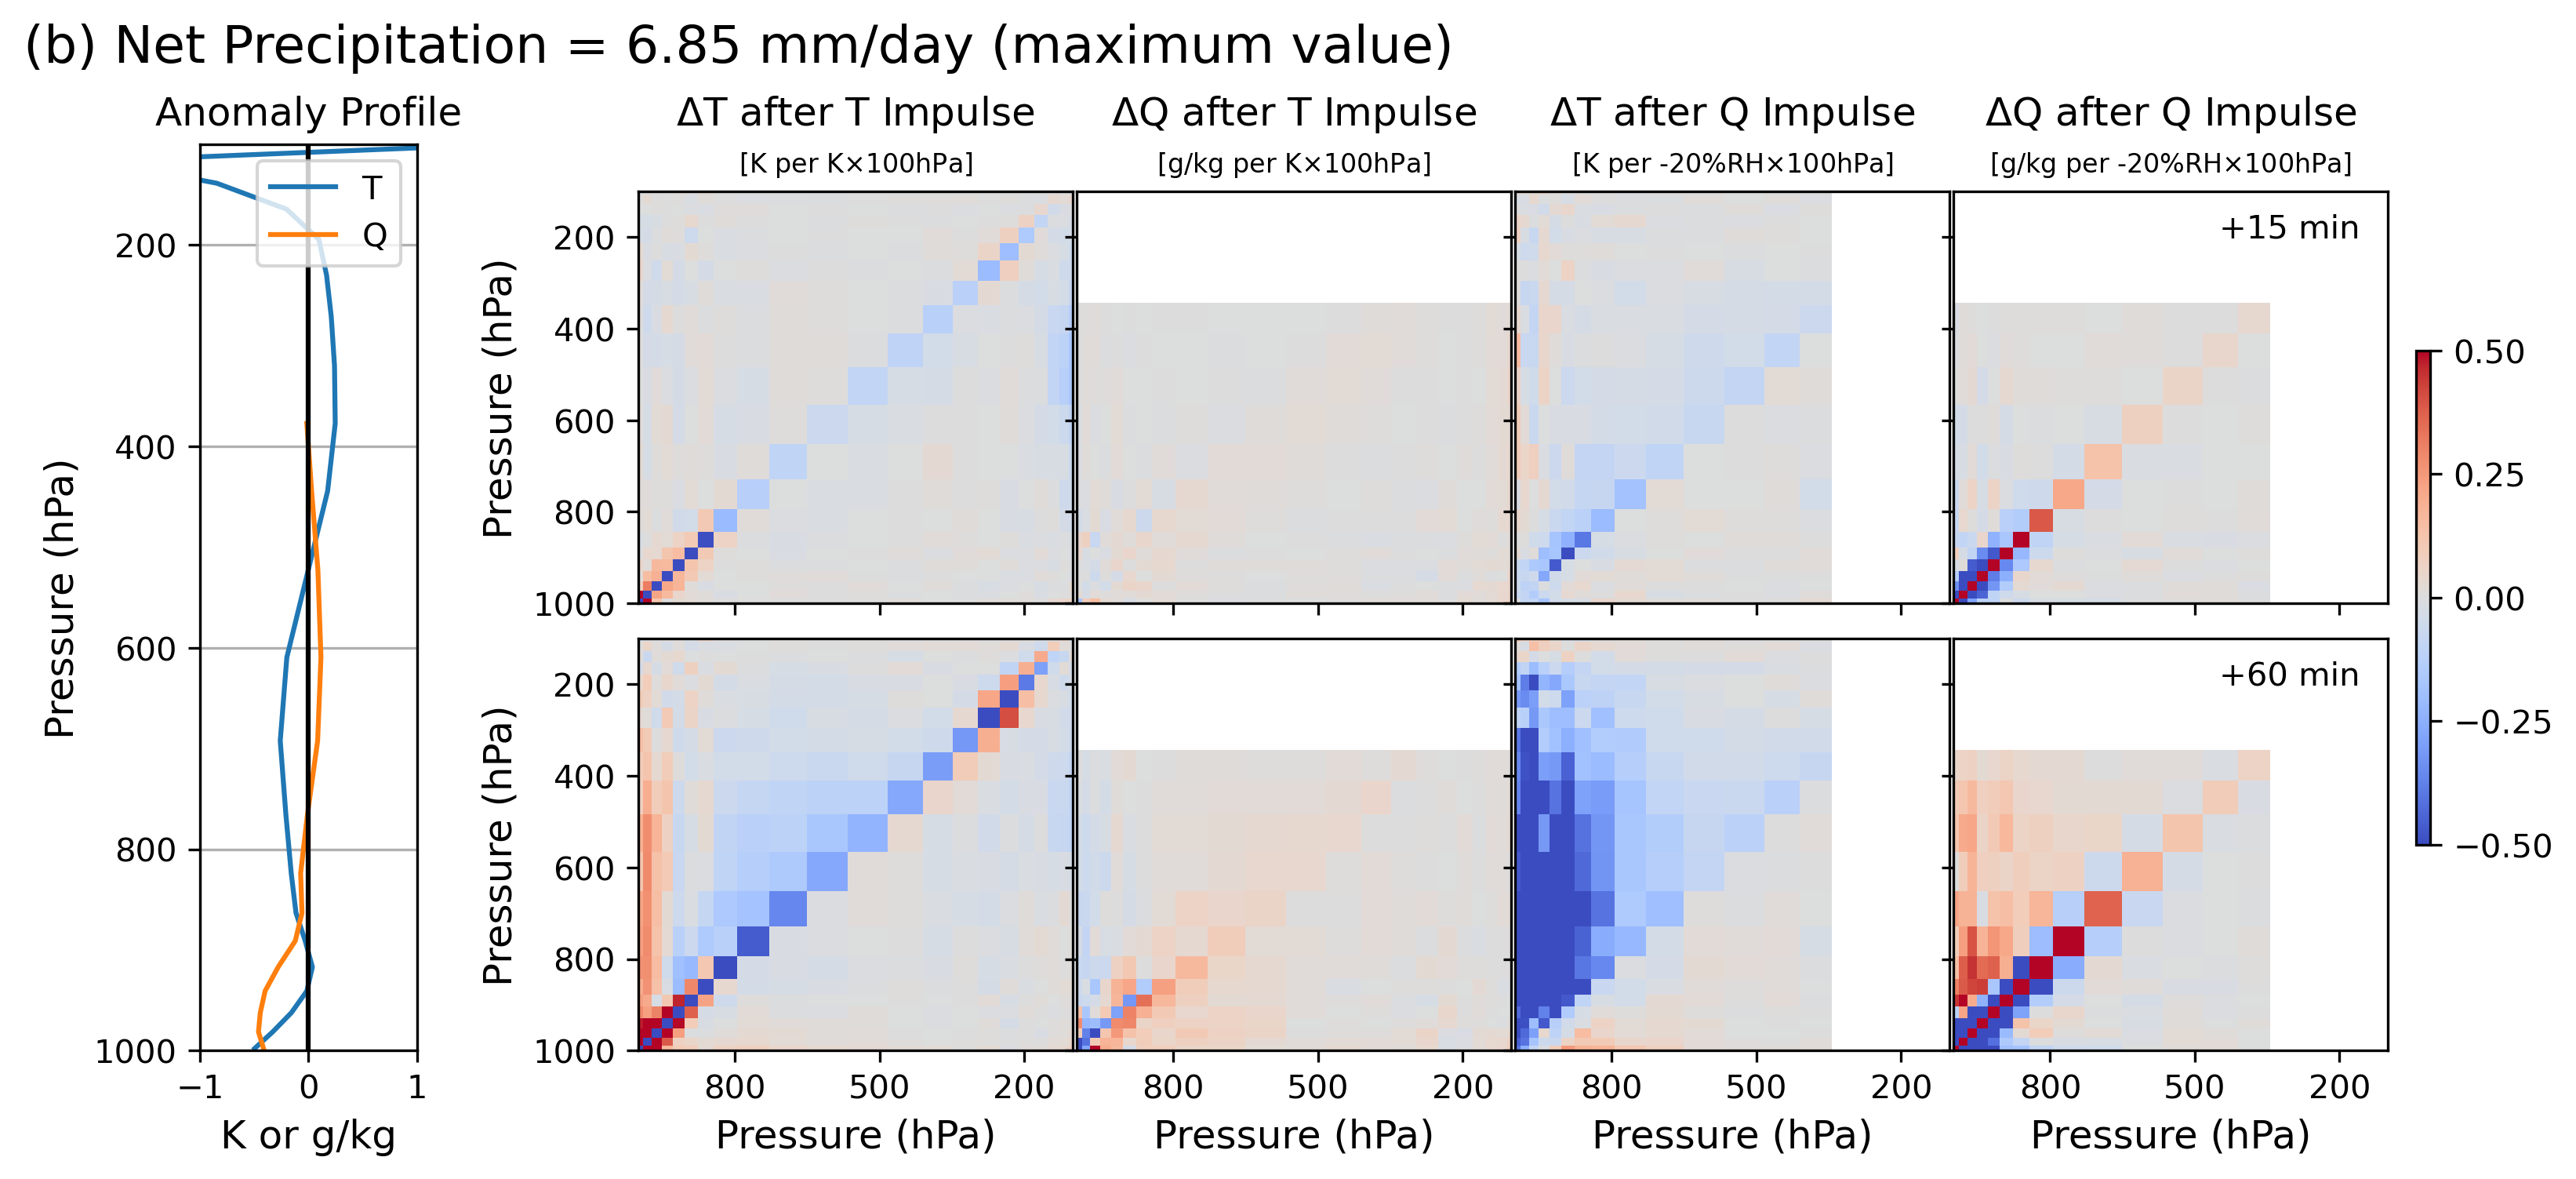

In [13]:
istep = 41*96+ind_max
i0 = results['iout'][:, istep:istep+1]
x0 = results['xout'][:, istep-1:istep]
Ap = A + dfdx(nonlinear_params, x0=x0, i0=i0)
tmp = np.linalg.solve(mass_weight, C)[:40, :64] @ (B @ mass_weight[:40, :40] + dfdi(nonlinear_params, x0=x0, i0=i0) @ mass_weight[:40, :40]) - np.identity(40)
for i in range(26):
    tmp[:, i] *= (100 / dp[i])
for i in range(14):
    tmp[:, i+26] *= -qg0[i] * 0.2 * (100 / dp[i])
    
fig = plt.figure(figsize=(12, 5), dpi=300)
gs = fig.add_gridspec(ncols=5, nrows=2, width_ratios=[1, 1, 1, 1, 1], height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax1.plot(results['tout'][:26, istep], grd_var['pres'][:26], label='T')
ax1.plot(results['qout'][:14, istep], grd_var['pres'][:14], label='Q')
ax1.legend(loc='upper right')
ax1.grid()
ax1.axvline(x=0, color='k')
ax1.set_ylim(1000, 100)
ax1.set_xlim(-1, 1)
ax1.set_title('Anomaly Profile', fontsize=12)

fig.subplots_adjust(wspace=0.01)
ax_tt1 = fig.add_subplot(gs[0, 1])
ax_qt1 = fig.add_subplot(gs[0, 2])
ax_tq1 = fig.add_subplot(gs[0, 3])
ax_qq1 = fig.add_subplot(gs[0, 4])
ax_tt2 = fig.add_subplot(gs[1, 1])
ax_qt2 = fig.add_subplot(gs[1, 2])
ax_tq2 = fig.add_subplot(gs[1, 3])
ax_qq2 = fig.add_subplot(gs[1, 4])

cmap = 'coolwarm'
cax0 = ax_tt1.pcolormesh(grd_var['pres'][:26], grd_var['pres'][:26], tmp[:26, :26], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_tt1.set_xlim(1000, 100)
ax_tt1.set_ylim(1000, 100)
ax_tt1.set_title(r'[K per K$\times$100hPa]', fontsize=8)

cax1 = ax_qt1.pcolormesh(grd_var['pres'][:26], grd_var['pres'][:14], tmp[26:40, :26], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_qt1.set_xlim(1000, 100)
ax_qt1.set_ylim(1000, 100)
ax_qt1.set_title(r'[g/kg per K$\times$100hPa]', fontsize=8)

cax2 = ax_tq1.pcolormesh(grd_var['pres'][:14], grd_var['pres'][:26], tmp[:26, 26:40], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_tq1.set_xlim(1000, 100)
ax_tq1.set_ylim(1000, 100)
ax_tq1.set_title(r'[K per -20%RH$\times$100hPa]', fontsize=8)

cax3 = ax_qq1.pcolormesh(grd_var['pres'][:14], grd_var['pres'][:14], tmp[26:40, 26:40], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_qq1.set_xlim(1000, 100)
ax_qq1.set_ylim(1000, 100)
ax_qq1.set_title(r'[g/kg per -20%RH$\times$100hPa]', fontsize=8)

tmp = np.linalg.solve(mass_weight, C)[:40, :64] @ Ap @ Ap @ Ap @ (B @ mass_weight[:40, :40] + dfdi(nonlinear_params, x0=x0, i0=i0) @ mass_weight[:40, :40]) - np.identity(40)
for i in range(26):
    tmp[:, i] *= (100 / dp[i])
for i in range(14):
    tmp[:, i+26] *= -qg0[i] * 0.2 * (100 / dp[i])
cax0 = ax_tt2.pcolormesh(grd_var['pres'][:26], grd_var['pres'][:26], tmp[:26, :26], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_tt2.set_xlim(1000, 100)
ax_tt2.set_ylim(1000, 100)
#ax_tt2.set_title(r'$\Delta$T from dT/dt', fontsize=14)

cax1 = ax_qt2.pcolormesh(grd_var['pres'][:26], grd_var['pres'][:14], tmp[26:40, :26], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_qt2.set_xlim(1000, 100)
ax_qt2.set_ylim(1000, 100)
#ax_qt2.set_title(r'$\Delta$Q from dT/dt', fontsize=14)

cax2 = ax_tq2.pcolormesh(grd_var['pres'][:14], grd_var['pres'][:26], tmp[:26, 26:40], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_tq2.set_xlim(1000, 100)
ax_tq2.set_ylim(1000, 100)
#ax_tq2.set_title(r'$\Delta$T from dQ/dt', fontsize=14)

cax3 = ax_qq2.pcolormesh(grd_var['pres'][:14], grd_var['pres'][:14], tmp[26:40, 26:40], vmin=-0.5, vmax=0.5, cmap=cmap, shading='auto')
ax_qq2.set_xlim(1000, 100)
ax_qq2.set_ylim(1000, 100)
#ax_qq2.set_title(r'$\Delta$Q from dQ/dt', fontsize=14)

pos_up = ax_qq1.get_position()
pos_down = ax_qq2.get_position()
cax = plt.axes([pos_up.x1+0.01, pos_down.y0+0.5*pos_down.height, 0.005, pos_up.y0-pos_down.y0])
cbar = fig.colorbar(cax0, cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-0.5, 0.5, 5))
#cbar.ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
#cbar.set_label('Scaled Unit', fontsize=12)

for ax in [ax_tt1, ax_qt1, ax_tq1, ax_qq1]:
    ax.set_xticklabels([])
for ax in [ax_qt1, ax_tq1, ax_qq1, ax_qt2, ax_tq2, ax_qq2]:
    ax.set_yticklabels([])
for ax in [ax_tt1, ax_tt2, ax_qt1, ax_tq1, ax_qq1, ax_qt2, ax_tq2, ax_qq2]:
    ax.set_xticks(np.linspace(200, 800, 3))
for ax in [ax_tt2, ax_qt2, ax_tq2, ax_qq2]:
    ax.set_xlabel('Pressure (hPa)', fontsize=12)
    
for ax in [ax_tt1, ax_tt2]:
    ax.set_ylabel('Pressure (hPa)', fontsize=12)

pos1 = ax_tt2.get_position()
new_pos1 = [pos1.x0, pos1.y0+pos1.height+0.03, pos1.width, pos1.height]  # Adjust position
ax_tt1.set_position(new_pos1)
pos1 = ax_qt2.get_position()
new_pos1 = [pos1.x0, pos1.y0+pos1.height+0.03, pos1.width, pos1.height]  # Adjust position
ax_qt1.set_position(new_pos1)
pos1 = ax_tq2.get_position()
new_pos1 = [pos1.x0, pos1.y0+pos1.height+0.03, pos1.width, pos1.height]  # Adjust position
ax_tq1.set_position(new_pos1)
pos1 = ax_qq2.get_position()
new_pos1 = [pos1.x0, pos1.y0+pos1.height+0.03, pos1.width, pos1.height]  # Adjust position
ax_qq1.set_position(new_pos1)
ax_qq1.text(450, 200, '+15 min')
ax_qq2.text(450, 200, '+60 min')

pos1 = ax1.get_position()
new_pos1 = [pos1.x0, pos1.y0, pos1.width*0.5, pos1.height]  # Adjust position
ax1.set_position(new_pos1)
ax1.set_yticks(np.linspace(200, 1000, 5))
ax1.set_xlabel('K or g/kg', fontsize=12)
ax1.set_ylabel('Pressure (hPa)', fontsize=12)
net_prec = round(results['iprecout_ml'][istep] - evap_diag[istep], 2)
fig.text(pos1.x0/2, 0.95, f'(b) Net Precipitation = {net_prec} mm/day (maximum value)', ha='left', fontsize=16)
ax_titles = [r'$\Delta$T after T Impulse', r'$\Delta$Q after T Impulse', r'$\Delta$T after Q Impulse', r'$\Delta$Q after Q Impulse']
for ind, ax in enumerate([ax_tt1, ax_qt1, ax_tq1, ax_qq1]):
    title = ax_titles[ind]
    pos_ax = ax.get_position()
    pos1 = ax1.get_position()
    fig.text(pos_ax.x0 + pos_ax.width/2, pos1.y0+pos1.height+0.009, f'{title}', ha='center', va='bottom', fontsize=12)